In [118]:
import os
import sys
import numpy as np
import torch
import clip
import dataset_loaders.voc_mlt as voc_mlt
import dataset_loaders.coco_mlt as coco_mlt
import importlib.util
from tqdm import tqdm
from torch import nn
from model_openai_clip import OpenAICLIPModel
from IPython.display import Image, display

config = "configs/voc_mlt_vitb16_nocaptions_clip.py"
checkpoint_name = "best_valid_mAP_tail"
zeroshot = False

run_name = config.split("/")[-1].replace(".py", "")
checkpoint_name = checkpoint_name.replace(".pt", "")

spec = importlib.util.spec_from_file_location("config_module", config)
config_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(config_module)
CFG = config_module.CFG

CFG.loss_function = []

DATASET = 'voc_mlt'
DATA_SPLIT = "valid"

# Search sample in dataset using CLIP
# Encode all images in dataset

# Load dataset

# Load the dataset
if CFG.dataset == "voc_mlt":
    data_loader = voc_mlt.build_loaders(
        root="dataset_loaders/voc_mlt",
        mode=DATA_SPLIT,
        image_size=CFG.size,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        class_caption=CFG.class_caption,
        use_dataset_train_captions=CFG.use_dataset_train_captions,
        use_sample_weights=False,
        use_data_augmentation=False,
    )
elif CFG.dataset == "coco_mlt":
    data_loader = coco_mlt.build_loaders(
        root="dataset_loaders/coco_mlt",
        mode=DATA_SPLIT,
        image_size=CFG.size,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        class_caption=CFG.class_caption,
        use_dataset_train_captions=CFG.use_dataset_train_captions,
        use_sample_weights=False,
        use_data_augmentation=False,
    )
else:
    raise ValueError("Only voc_mlt and coco_mlt are supported as datasets")

num_labels = data_loader.dataset.num_classes

# Load the model from the checkpoint
clip_model, image_preprocessor = clip.load(
    CFG.model_name, device=CFG.device, jit=False
)
clip_model = clip_model.float()
model = OpenAICLIPModel(
    config=CFG,
    clip_model=clip_model,
    train_class_weights=None,
    valid_class_weights=None,
).to(CFG.device)

# Load from checkpoint
if not zeroshot:
    checkpoint = torch.load(f"runs/{run_name}/{checkpoint_name}.pt")
    model.load_state_dict(checkpoint["model_state_dict"])
    epoch = checkpoint["epoch"]
    print(f"Loaded run {run_name} checkpoint {checkpoint_name} at epoch {epoch}")
else:
    epoch = "NONE"
    print(f"Loaded config {run_name} for CLIP zero-shot evaluation")

{'head': {4, 6, 8, 10, 14, 15}, 'middle': {1, 7, 11, 13, 17, 19}, 'tail': {0, 2, 3, 5, 9, 12, 16, 18}}
Tokenizing captions...
Class aeroplane has 205 occurences, weight is 24.15609756097561.
Class bicycle has 250 occurences, weight is 19.808.
Class bird has 289 occurences, weight is 17.134948096885815.
Class boat has 176 occurences, weight is 28.136363636363637.
Class bottle has 240 occurences, weight is 20.633333333333333.
Class bus has 183 occurences, weight is 27.060109289617486.
Class car has 775 occurences, weight is 6.389677419354839.
Class cat has 332 occurences, weight is 14.91566265060241.
Class chair has 545 occurences, weight is 9.086238532110091.
Class cow has 127 occurences, weight is 38.99212598425197.
Class diningtable has 247 occurences, weight is 20.048582995951417.
Class dog has 433 occurences, weight is 11.4364896073903.
Class horse has 279 occurences, weight is 17.74910394265233.
Class motorbike has 233 occurences, weight is 21.253218884120173.
Class person has 2097

In [119]:
# Calculate tokens for the labels
encoded_labels = torch.cat(
    [
        clip.tokenize(label, context_length=CFG.max_length)
        for label in data_loader.dataset.label_strings
    ]
).to(CFG.device)

# Calculate text embeddings for the labels
with torch.no_grad():
    label_embeddings = model.model.encode_text(encoded_labels)
    label_embeddings = label_embeddings / label_embeddings.norm(
        dim=-1, keepdim=True
    )

ids = []
image_features = []
caption_features = []
classes_one_hot = []
predictions = []

tqdm_object = tqdm(data_loader, total=len(data_loader))
activation_function = nn.Softmax(dim=1)
# activation_function = nn.Sigmoid()

class_predictions = {}
for i in range(num_labels):
    class_predictions[i] = {
        "image_features": [],
        "caption_features": [],
        "classes_one_hot": [],
        "predictions": [],
    }

for batch in tqdm_object:
    batch = {k: v.to(CFG.device) for k, v in batch.items()}

    with torch.no_grad():
        image_embeddings = model.model.encode_image(batch["image"])
        caption_embeddings = model.model.encode_text(batch["caption"])

        image_embeddings = image_embeddings / image_embeddings.norm(
            dim=-1, keepdim=True
        )
        caption_embeddings = caption_embeddings / caption_embeddings.norm(
            dim=-1, keepdim=True
        )

    # Add samples that have the classes we want to sample
    for i in range(batch["label_one_hot"].shape[0]):
        ids.append(batch["idx"][i])
        image_features.append(image_embeddings[i].unsqueeze(0))
        caption_features.append(caption_embeddings[i].unsqueeze(0))
        classes_one_hot.append(batch["label_one_hot"][i].unsqueeze(0))

        with torch.no_grad():
            logit_scale = model.model.logit_scale.exp()
            dot_similarity = (
                logit_scale * image_embeddings[i].unsqueeze(0) @ label_embeddings.T
            )
        preds = activation_function(dot_similarity)

        predictions.append(preds)

image_features = torch.cat(image_features, dim=0)
caption_features = torch.cat(caption_features, dim=0)
classes_one_hot = torch.cat(classes_one_hot, dim=0)
predictions = torch.cat(predictions, dim=0)

  0%|          | 0/619 [00:00<?, ?it/s]

100%|██████████| 619/619 [00:10<00:00, 58.71it/s]


Image 495
Predictions:
a photo of a cow: 86.9
a photo of a horse: 7.852
a photo of a person: 3.866
a photo of a sheep: 0.842
a photo of a dog: 0.3973


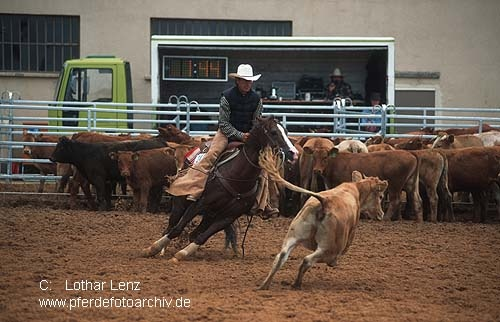

Image 997
Predictions:
a photo of a boat: 74.43
a photo of a person: 10.06
a photo of a cow: 9.101
a photo of a horse: 2.353
a photo of a dog: 1.771


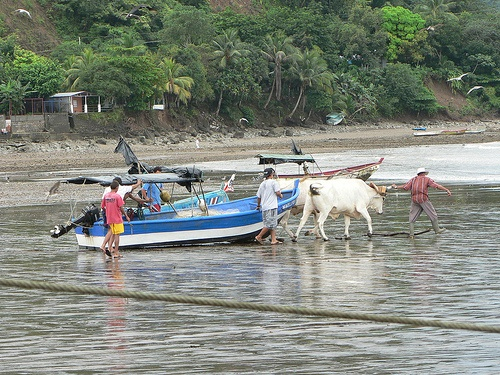

Image 2262
Predictions:
a photo of a horse: 80.13
a photo of a dog: 18.69
a photo of a cow: 0.6085
a photo of a person: 0.4499
a photo of a sheep: 0.05322


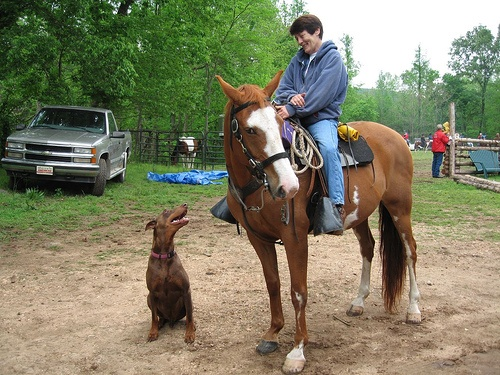

Image 4281
Predictions:
a photo of a cow: 53.96
a photo of a horse: 33.93
a photo of a person: 9.484
a photo of a sheep: 1.941
a photo of a dog: 0.4005


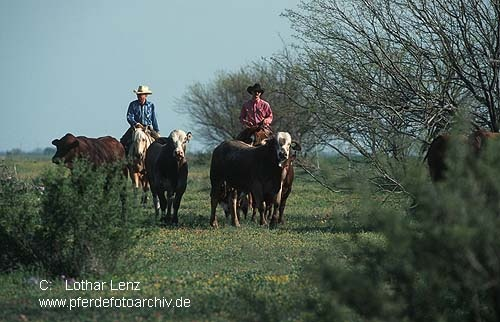

In [120]:
image_ids = [495, 997, 2262, 4281]

# Check predictions of images
for i in image_ids:
    print(f"Image {i}")

    # Sort predictions
    sorted_predictions = torch.argsort(predictions[i], descending=True)

    # Print predictions as mathematically formatted string with e-notation except +01
    print("Predictions:")
    for j in range(5):
        print(
            f"{data_loader.dataset.label_strings[sorted_predictions[j]]}: {predictions[i][sorted_predictions[j]]*100:.4g}"
        )

    # Show the image
    image = data_loader.dataset.image_paths[i]
    image = os.path.join(data_loader.dataset.root, image)
    image = Image(filename=image)
    display(image)

Image ID: 3162


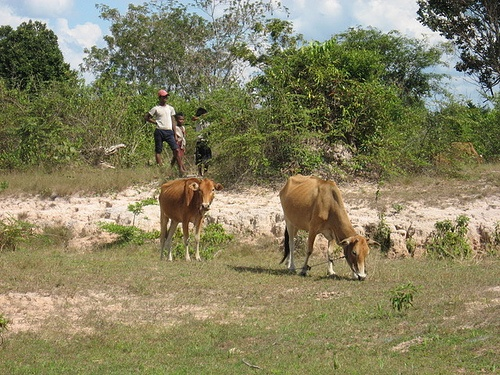

Image ID: 4594


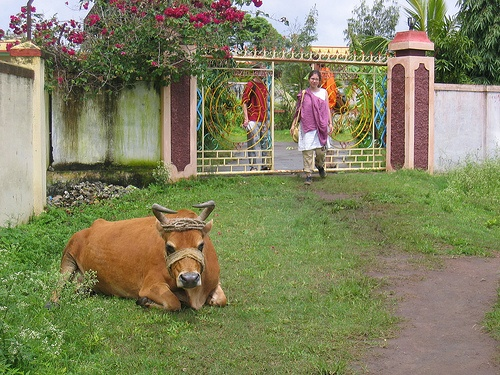

Image ID: 4852


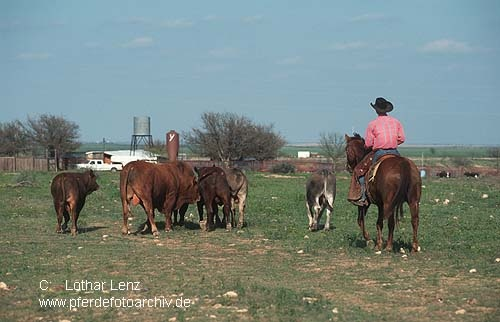

Image ID: 4940


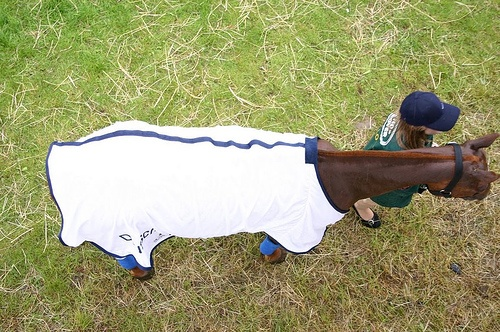

Image ID: 495


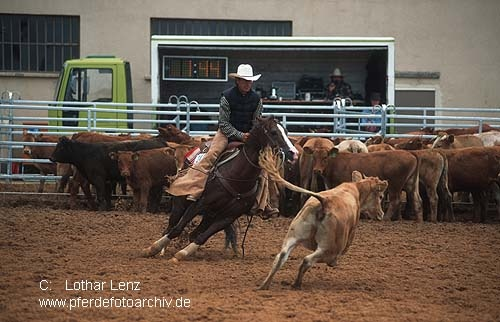

Image ID: 1636


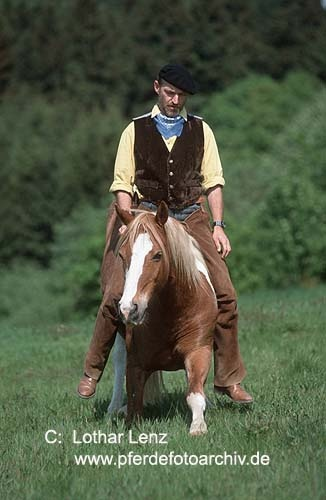

Image ID: 2170


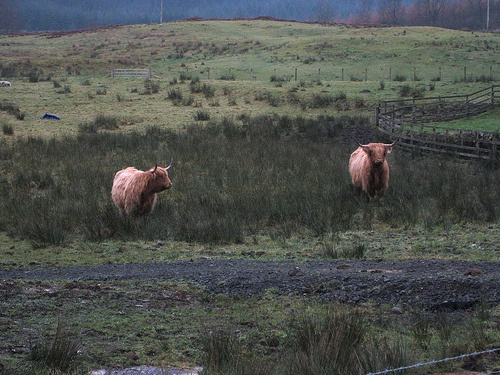

Image ID: 4392


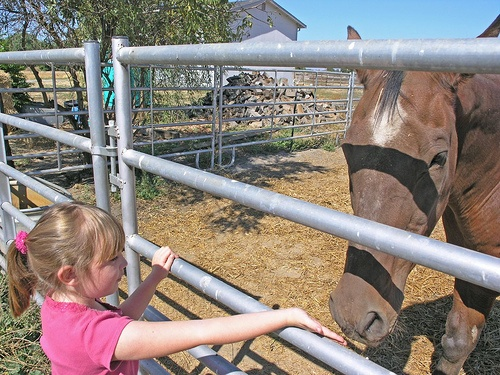

Image ID: 4281


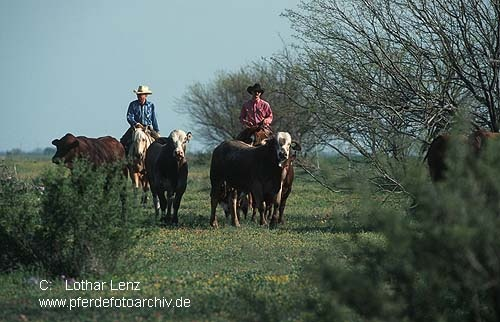

Image ID: 1046


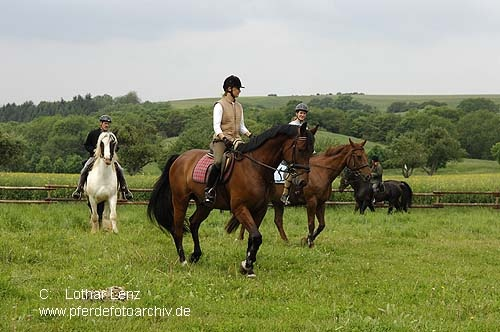

Image ID: 3936


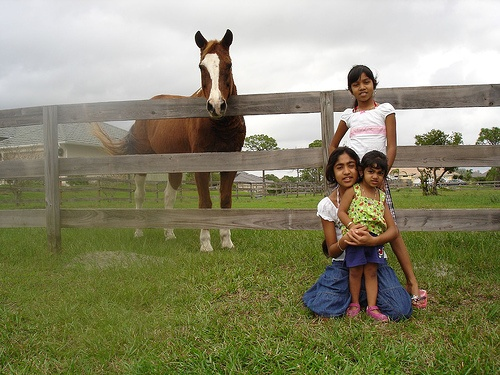

Image ID: 1168


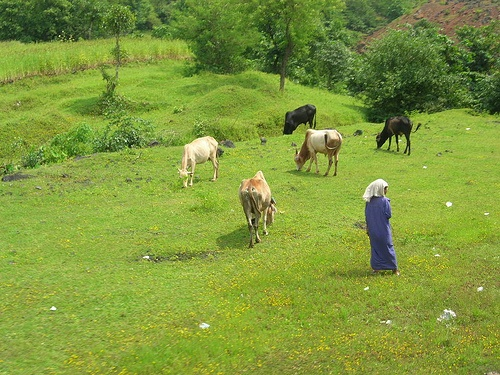

Image ID: 3017


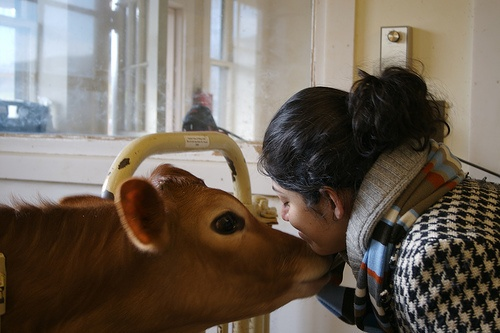

Image ID: 1386


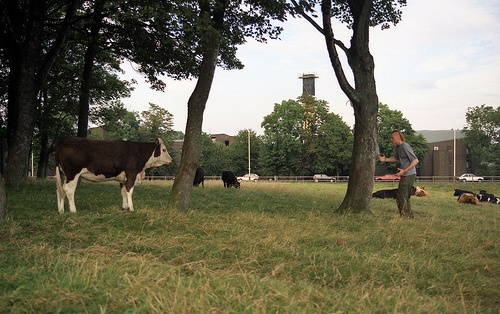

Image ID: 194


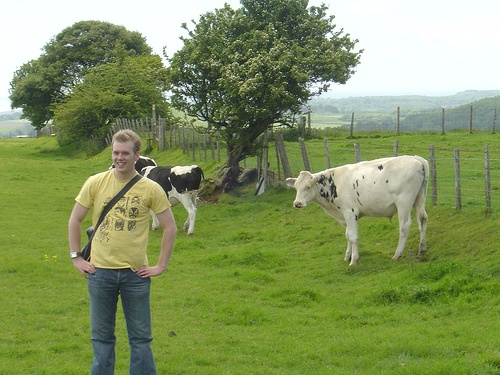

Image ID: 149


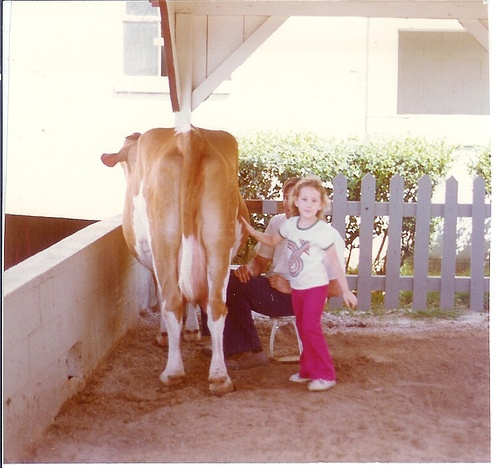

Image ID: 2399


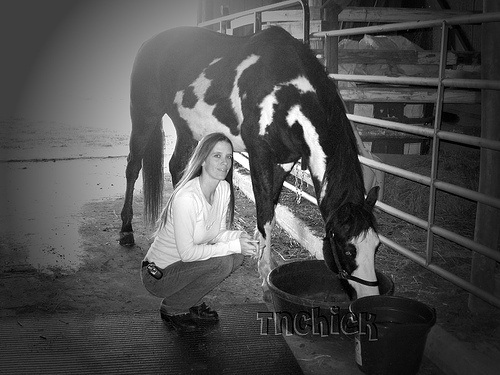

Image ID: 1984


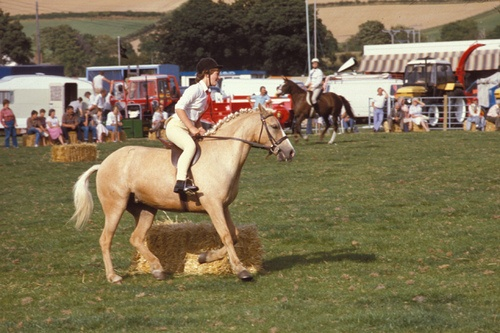

Image ID: 3210


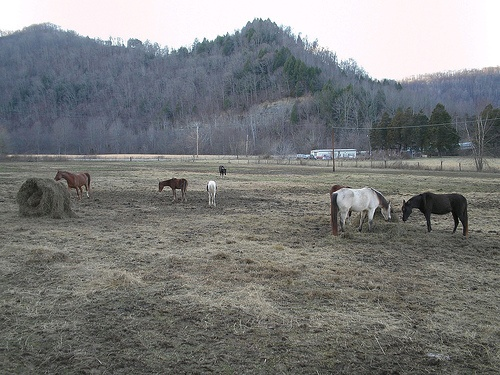

Image ID: 2262


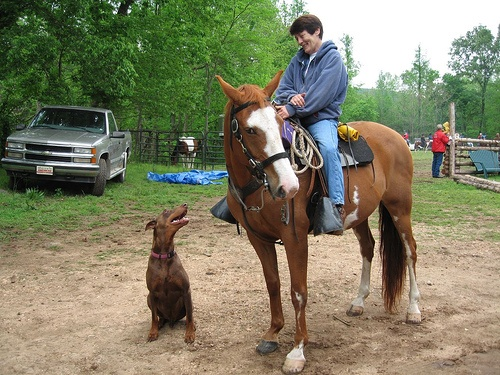

In [121]:
# Encode search text
search_text = "a photo of a person, cow, horse"
search_text = clip.tokenize(search_text, context_length=CFG.max_length).to(CFG.device)
search_text = model.model.encode_text(search_text)
search_text = search_text / search_text.norm(dim=-1, keepdim=True)

# Calculate similarity between search text and all labels
similiarities = torch.zeros(image_features.shape[0])

with torch.no_grad():
    logit_scale = model.model.logit_scale.exp()
    # Compare similarity between search text and all image_features
    for i in range(image_features.shape[0]):
        dot_similarity = logit_scale *  image_features[i] @ search_text.T
        similiarities[i] = dot_similarity

# Sort the similarities
sorted_similarities, sorted_indices = torch.sort(similiarities, descending=True)

k = 20
# Get k most similar samples
for i in range(k):
    idx = sorted_indices[i].item()
    print(f"Image ID: {ids[idx]}")
    
    # Show the image
    image = data_loader.dataset.image_paths[idx]
    image = os.path.join(data_loader.dataset.root, image)
    image = Image(filename=image)
    display(image)